In [1]:
# Degradation Demo:
!pip install --target=$nb_path pzflow
!pip install git+https://github.com/LSSTDESC/RAIL.git#egg=rail[Full]
!git clone https://github.com/COINtoolbox/photoz_catalogues.git 

import matplotlib
matplotlib.use('Agg')
import pylab as pb
from pzflow.examples import example_flow
from rail.creation import Creator, engines
from rail.creation.degradation import InvRedshiftIncompleteness, LineConfusion
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpl_patches
import csv


     |████████████████████████████████| 7.9 MB 6.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pzflow: filename=pzflow-1.7.1-py3-none-any.whl size=7181860 sha256=a13fadf1806f49d9e45dc2ba4092c9c343bb0b70982479541e247774de7700d2
  Stored in directory: /root/.cache/pip/wheels/77/5a/38/f20c39240eeff5075e6b33a1afbfa46f065b345e625d10f979
Successfully built pzflow
  Cloning https://github.com/LSSTDESC/RAIL.git to /tmp/pip-install-qj0i_4v5/rail_d98b2657fd0a472cb24bf96a5cf34125
  Running command git clone -q https://github.com/LSSTDESC/RAIL.git /tmp/pip-install-qj0i_4v5/rail_d98b2657fd0a472cb24bf96a5cf34125
  Cloning https://github.com/LSSTDESC/DESC_BPZ to /tmp/pip-install-qj0i_4v5/desc-bpz_aba8626531ae46c8928903498926c56c
  Running command git clone -q https://github.com/LSSTDESC/DESC_BPZ /tmp/pip-install-qj0i_4v5/desc-bpz_aba8626531ae46c8928903

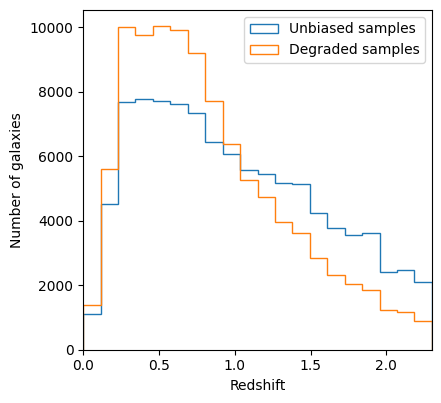

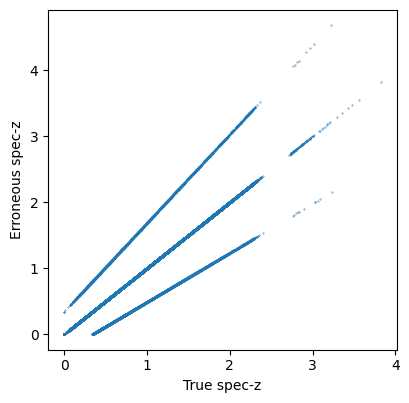

In [113]:
flow = engines.FlowEngine(example_flow())
creator = Creator(flow)
degraded_creator = Creator(flow, degrader=InvRedshiftIncompleteness(0.8))

samples = creator.sample(100000)
degraded_samples = degraded_creator.sample(100000)

fig, ax = plt.subplots(figsize=(4.5,4.5), dpi=100)
ax.hist(samples['redshift'], bins=20, range=(0,2.3), histtype='step', label="Unbiased samples")
ax.hist(degraded_samples['redshift'], bins=20, range=(0,2.3), histtype='step', label="Degraded samples")
ax.legend()
ax.set(xlabel="Redshift", ylabel="Number of galaxies", xlim=(0,2.3))
plt.show()
pb.savefig("//content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_degradation_1.pdf")
np.savetxt('/content/drive/MyDrive/Coding/Data/Badness=5/samples.csv',samples, delimiter=',')
combined_pdfs=np.genfromtxt('/content/drive/MyDrive/Coding/Data/Badness=5/samples.csv', delimiter=',')

degraded_samples.shape == samples.shape

def OxygenLineConfusion(data, seed=None):
    OII = 3727
    OIII = 5007
    badness = 5
    data = LineConfusion(true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02*badness)(data, seed)
    data = LineConfusion(true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01*badness)(data, seed)
    return data

flow = engines.FlowEngine(example_flow())
creator = Creator(flow)
degraded_creator = Creator(flow, degrader=OxygenLineConfusion)

samples = creator.sample(100000, seed=0)
degraded_samples = degraded_creator.sample(100000, seed=0)

fig, ax = plt.subplots(figsize=(4.5,4.5), dpi=100)
ax.scatter(samples["redshift"], degraded_samples["redshift"], s=0.1)
ax.set(xlabel="True spec-z", ylabel="Erroneous spec-z")
plt.show()
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_degradation_2.pdf")
np.savetxt('/content/drive/MyDrive/Coding/Data/Badness=5/degraded_samples.csv', degraded_samples, delimiter=',')
combined_pdfs=np.genfromtxt('/content/drive/MyDrive/Coding/Data/Badness=5/degraded_samples.csv', delimiter=',')


In [134]:
# Degraded Samples Photo-z:

import matplotlib
matplotlib.use('Agg')
import sys
sys.path.append('/content/drive/MyDrive/Coding')
import GPz
from numpy import *
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pylab as pb
from matplotlib.gridspec import GridSpec

########### Model options ###############

method = 'VC'               # select method, options = GL, VL, GD, VD, GC and VC [required]
                            #
m = 50                      # number of basis functions to use [required]
                            #
joint = True                # jointly learn a prior linear mean function [default=true]
                            #
heteroscedastic = True      # learn a heteroscedastic noise process, set to false interested only in point estimates
                            #
csl_method = 'normal'       # cost-sensitive learning option: [default='normal']
                            #       'balanced':     to weigh rare samples more heavly during train
                            #       'normalized':   assigns an error cost for each sample = 1/(z+1)
                            #       'normal':       no weights assigned, all samples are equally important
                            #
binWidth = 0.1              # the width of the bin for 'balanced' cost-sensitive learning [default=range(z_spec)/100]

decorrelate = True          # preprocess the data using PCA [default=False]

########### Training options ###########

dataPath_samples = '/content/drive/MyDrive/Coding/Data/Badness=2/samples.csv'    # path to the data set, has to be in the following format m_1,m_2,..,m_k,e_1,e_2,...,e_k,z_spec
                                        # where m_i is the i-th magnitude, e_i is its associated uncertainty and z_spec is the spectroscopic redshift
                                        # [required]
dataPath_degraded_samples = '/content/drive/MyDrive/Coding/Data/Badness=2/degraded_samples.csv'


maxIter = 500                   # maximum number of iterations [default=200]
maxAttempts = 50              # maximum iterations to attempt if there is no progress on the validation set [default=infinity]
trainSplit = 0.2               # percentage of data to use for training
validSplit = 0.2               # percentage of data to use for validation
testSplit  = 0.6               # percentage of data to use for testing

########### Start of script ###########

# Load samples
# read data from file
data = loadtxt(open(dataPath_samples,"rb"),delimiter=",")

X_samples = data[:, 1:6]
n,d = X_samples.shape
Y_samples = data[:, 0].reshape(n, 1)

filters = d/2

# log the uncertainties of the magnitudes, any additional preprocessing should be placed here
X_samples[:, int(filters):] = log(X_samples[:, int(filters):])



# Load degraded_samples
# read data from file
data_2 = loadtxt(open(dataPath_degraded_samples,"rb"),delimiter=",")

X_degraded_samples = data_2[:, 1:6]
n,d = X_degraded_samples.shape
Y_degraded_samples = data_2[:, 0].reshape(n, 1)

filters = d/2

# log the uncertainties of the magnitudes, any additional preprocessing should be placed here
X_degraded_samples[:, int(filters):] = log(X_degraded_samples[:, int(filters):])




# sample training, validation and testing sets from the data
training,validation,testing = GPz.sample(n,trainSplit,validSplit,testSplit)

# you can also select the size of each sample
# training,validation,testing = GPz.sample(n,10000,10000,10000)

# get the weights for cost-sensitive learning
omega = GPz.getOmega(Y_samples, method=csl_method)




# initialize the initial model
model_samples = GPz.GP(m,method=method,joint=joint,heteroscedastic=heteroscedastic,decorrelate=decorrelate)

# train the model
model_samples.train(X_samples.copy(), Y_samples.copy(), omega=omega, training=training, validation=validation, maxIter=maxIter, maxAttempts=maxAttempts)

########### NOTE ###########
# you can train the model gain, eve using different data, by executing:
# model.train(model,X,Y,options)

# use the model to generate predictions for the test set
mu_samples,sigma_samples,modelV_samples,noiseV_samples,_ = model_samples.predict(X_samples[testing,:].copy())




# initialize the initial model
model_degraded_samples = GPz.GP(m,method=method,joint=joint,heteroscedastic=heteroscedastic,decorrelate=decorrelate)

# train the model
model_degraded_samples.train(X_degraded_samples.copy(), Y_degraded_samples.copy(), omega=omega, training=training, validation=validation, maxIter=maxIter, maxAttempts=maxAttempts)

########### NOTE ###########
# you can train the model gain, eve using different data, by executing:
# model.train(model,X,Y,options)

# use the model to generate predictions for the test set
mu_degraded_samples,sigma_degraded_samples,modelV_degraded_samples,noiseV_degraded_samples,_ = model_degraded_samples.predict(X_samples[testing,:].copy())






########### Display Results ###########

# compute metrics   (compared to samples - true redshifts)
rmse_samples = sqrt(GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: (y-mu)**2))
mll_samples  = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: -0.5*(y-mu)**2/sigma-0.5*log(sigma)-0.5*log(2*pi))
fr15_samples = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.15))
fr05_samples = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.05))
bias_samples = GPz.metrics(Y_samples[testing],mu_samples,sigma_samples,lambda y,mu,sigma: y-mu)



# compute metrics   (compared to samples - true redshifts)
rmse_degraded_samples = sqrt(GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: (y-mu)**2))
mll_degraded_samples  = GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: -0.5*(y-mu)**2/sigma-0.5*log(sigma)-0.5*log(2*pi))
fr15_degraded_samples = GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.15))
fr05_degraded_samples = GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: 100.0*(abs(y-mu)/(y+1.0)<0.05))
bias_degraded_samples = GPz.metrics(Y_samples[testing],mu_degraded_samples,sigma_degraded_samples,lambda y,mu,sigma: y-mu)




# print metrics for the entire data
print(('{0:4s}\t\t\t{1:3s}\t\t\t{2:6s}\t\t\t{3:6s}\t\t\t{4:4s}'.format('RMSE', ' MLL', ' FR15', ' FR05', ' BIAS')))
print(('{0:1.7e}\t{1: 1.7e}\t{2: 1.7e}\t{3: 1.7e}\t{4: 1.7e}'.format(rmse_samples[-1], mll_samples[-1], fr15_samples[-1],fr05_samples[-1],bias_samples[-1])))
print(('{0:1.7e}\t{1: 1.7e}\t{2: 1.7e}\t{3: 1.7e}\t{4: 1.7e}'.format(rmse_degraded_samples[-1], mll_degraded_samples[-1], fr15_degraded_samples[-1],fr05_degraded_samples[-1],bias_degraded_samples[-1])))


Iter	 logML/n 		 Train RMSE		 Train RMSE/n		 Valid RMSE		 Valid MLL		 Time    
   1	-6.1780092e-01	 4.0593102e-01	-5.9953295e-01	 4.0592686e-01	[-5.9959343e-01]	 1.9525273e+00
   2	-5.1215506e-01	 3.5678759e-01	-4.6836328e-01	 3.5635435e-01	[-4.6675354e-01]	 1.8966396e+00
   3	-4.8998870e-01	 3.4565270e-01	-4.5313951e-01	 3.4422768e-01	[-4.4653720e-01]	 1.8849432e+00
   4	-4.8369513e-01	 3.4474328e-01	-4.4768786e-01	 3.4314957e-01	[-4.4034811e-01]	 1.8608048e+00
   5	-4.7338713e-01	 3.4412084e-01	-4.3771551e-01	 3.4245205e-01	[-4.3025940e-01]	 1.2869294e+00
   6	-4.5471153e-01	 3.4297852e-01	-4.1919999e-01	 3.4102127e-01	[-4.1065512e-01]	 1.2486513e+00
   7	-4.2661586e-01	 3.4250521e-01	-3.9533680e-01	 3.4080494e-01	[-3.8839640e-01]	 1.2428992e+00
   8	-3.9833635e-01	 3.4418275e-01	-3.7584845e-01	 3.4273470e-01	[-3.7050296e-01]	 1.2307208e+00
   9	-3.6744448e-01	 3.4306436e-01	-3.5453243e-01	 3.4044725e-01	[-3.4576858e-01]	 1.2545156e+00
  10	-3.5380864e-01	 3.4320751e-01	-3.4625325e-0

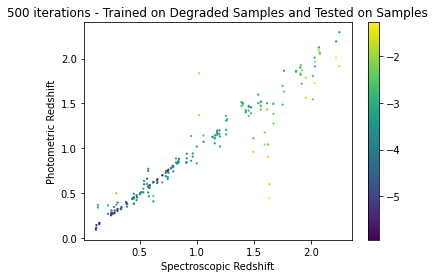

In [115]:
# plot scatter plots for density and uncertainty
f = plt.figure(1)
plt.scatter(Y_samples[testing,:][0:100],mu_samples[0:100],s=5, c=log(squeeze(sigma_samples))[0:100], edgecolor=['none'])
plt.scatter(Y_samples[testing,:][0:100],mu_degraded_samples[0:100],s=5, c=log(squeeze(sigma_degraded_samples))[0:100], edgecolor=['none'])
plt.colorbar()
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.title('500 iterations - Trained on Degraded Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_1.pdf", dpi=300, bbox_inches = "tight")

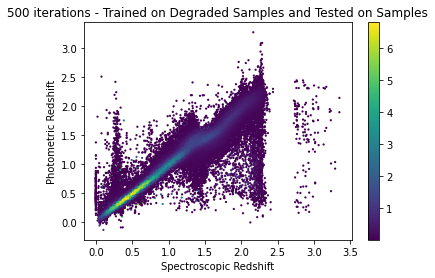

In [116]:
f = plt.figure(2)
xy = hstack([Y_samples[testing,:],mu_samples]).T
xy = hstack([Y_samples[testing,:],mu_degraded_samples]).T
z = gaussian_kde(xy)(xy)
plt.scatter(Y_samples[testing,:],mu_samples,s=5, c=z, edgecolor=['none'])
plt.scatter(Y_samples[testing,:],mu_degraded_samples,s=5, c=z, edgecolor=['none'])
plt.colorbar()
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Photometric Redshift')
plt.title('500 iterations - Trained on Degraded Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_2.pdf", dpi=300, bbox_inches = "tight")

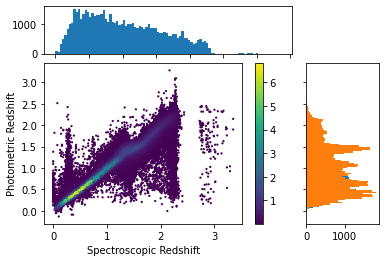

In [118]:
# marginal histograms of spectroscopic redshifts and photometric redshift estimates
f = plt.figure(2.1)

gs = GridSpec(4,4)

ax_joint = f.add_subplot(gs[1:4,0:3])
ax_marg_x = f.add_subplot(gs[0,0:3])
ax_marg_y = f.add_subplot(gs[1:4,3])

xy_s = hstack([Y_samples[testing,:],mu_samples]).T
xy_ds = hstack([Y_samples[testing,:],mu_degraded_samples]).T
z_s = gaussian_kde(xy_s)(xy_s)
z_ds = gaussian_kde(xy_ds)(xy_ds)

#ax_joint.scatter(Y_samples[testing,:], mu_samples, s=5, c=z, edgecolor=['none'])
im = ax_joint.scatter(Y_samples[testing,:], mu_samples, s=5, c=z_s, cmap=plt.cm.viridis, edgecolor=['none'])
im = ax_joint.scatter(Y_samples[testing,:], mu_degraded_samples, s=5, c=z_ds, cmap=plt.cm.viridis, edgecolor=['none'])
f.colorbar(im, ax=ax_joint)

ax_marg_x.hist(Y_samples[testing,:], bins=100)
ax_marg_y.hist(mu_samples,orientation="horizontal", bins=100)
ax_marg_y.hist(mu_degraded_samples,orientation="horizontal", bins=100)

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Spectroscopic Redshift')
ax_joint.set_ylabel('Photometric Redshift')

# Set labels on marginals
#ax_marg_y.set_xlabel('Marginal x label')
#ax_marg_x.set_ylabel('Marginal y label')

#ax_joint.set_title('2 iterations - Trained on Samples and Tested on Samples', loc='center')

#pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_2.1.pdf", dpi=300, bbox_inches = "tight")
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_2.2.pdf", dpi=300, bbox_inches = "tight")

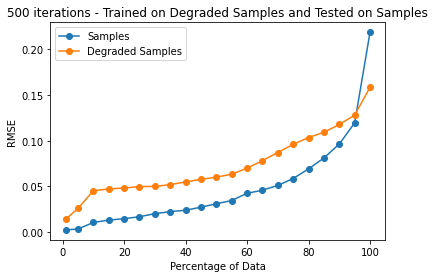

In [119]:
# plot the change in metrics as functions of data percentage
x = array(list(range(0,20+1)))*5
x[0]=1

ind_s = x*len(rmse_samples) // 100
ind_ds = x*len(rmse_degraded_samples) // 100

f = plt.figure(3)
plt.plot(x,rmse_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,rmse_degraded_samples[ind_ds-1],'o-', label="Degraded Samples")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('RMSE')
plt.title('500 iterations - Trained on Degraded Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_3_rmse.pdf", dpi=300, bbox_inches = "tight")

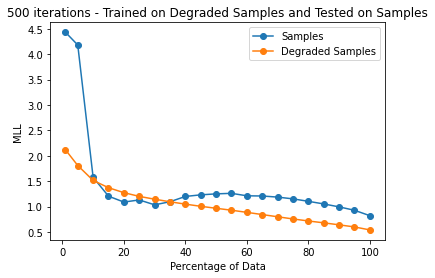

In [120]:
f = plt.figure(4)
plt.plot(x,mll_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,mll_degraded_samples[ind_ds-1],'o-',  label="Degraded Samples")
plt.legend(loc='upper right')
plt.xlabel('Percentage of Data')
plt.ylabel('MLL')
plt.title('500 iterations - Trained on Degraded Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_4_mll.pdf", dpi=300, bbox_inches = "tight")

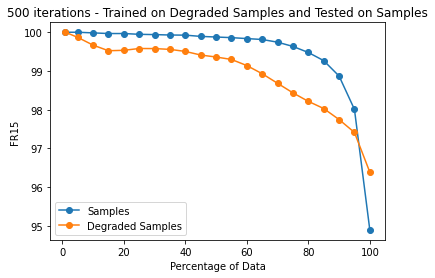

In [121]:
f = plt.figure(5)
plt.plot(x,fr15_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,fr15_degraded_samples[ind_ds-1],'o-', label="Degraded Samples")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('FR15')
plt.title('500 iterations - Trained on Degraded Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_5_fr15.pdf", dpi=300, bbox_inches = "tight")

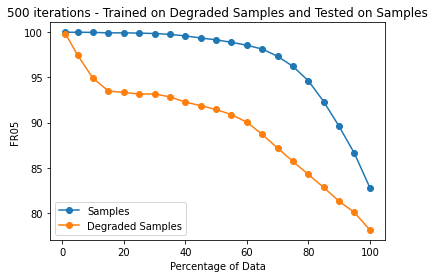

In [122]:
f = plt.figure(6)
plt.plot(x,fr05_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,fr05_degraded_samples[ind_ds-1],'o-',  label="Degraded Samples")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('FR05')
plt.title('500 iterations - Trained on Degraded Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_6_fr05.pdf", dpi=300, bbox_inches = "tight")

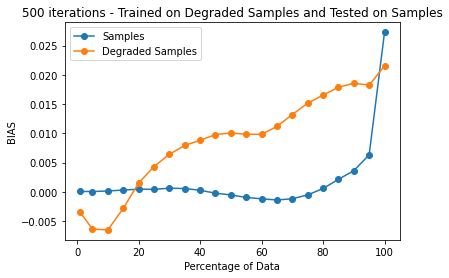

In [123]:
f = plt.figure(7)
plt.plot(x,bias_samples[ind_s-1],'o-', label="Samples")
plt.plot(x,bias_degraded_samples[ind_ds-1],'o-', label="Degraded Samples")
plt.legend()
plt.xlabel('Percentage of Data')
plt.ylabel('BIAS')
plt.title('500 iterations - Trained on Degraded Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_7_bias.pdf", dpi=300, bbox_inches = "tight")


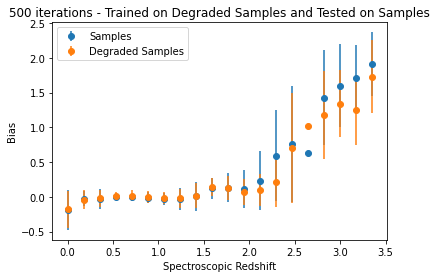

In [124]:
# plot mean and standard deviation of different scores as functions of spectroscopic redshift using 20 bins
f = plt.figure(8)
centers_s,means_s,stds_s = GPz.bin(Y_samples[testing],Y_samples[testing]-mu_samples,20)
centers_ds,means_ds,stds_ds = GPz.bin(Y_samples[testing],Y_samples[testing]-mu_degraded_samples,20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'Samples')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'Degraded Samples')
plt.legend(loc='upper left')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Bias')
plt.title('500 iterations - Trained on Degraded Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_8_bias.pdf", dpi=300, bbox_inches = "tight")

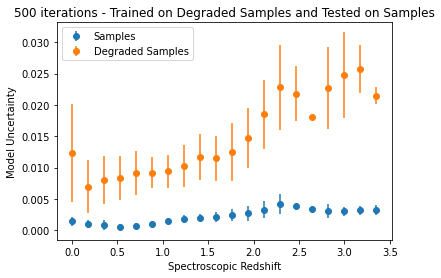

In [125]:
f = plt.figure(9)
centers_s,means_s,stds_s = GPz.bin(Y_samples[testing],sqrt(modelV_samples),20)
centers_ds,means_ds,stds_ds = GPz.bin(Y_samples[testing],sqrt(modelV_degraded_samples),20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'Samples')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'Degraded Samples')
plt.legend(loc='upper left')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Model Uncertainty')
plt.title('500 iterations - Trained on Degraded Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_9_modelV.pdf", dpi=300, bbox_inches = "tight")

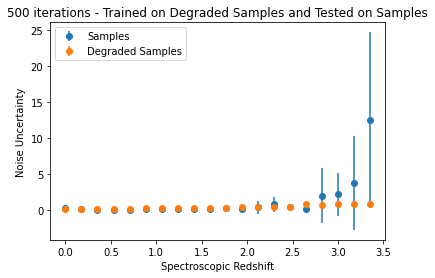

In [126]:
f = plt.figure(10)
centers_s,means_s,stds_s = GPz.bin(Y_samples[testing],sqrt(noiseV_samples),20)
centers_ds,means_ds,stds_ds = GPz.bin(Y_samples[testing],sqrt(noiseV_degraded_samples),20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'Samples')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'Degraded Samples')
plt.legend(loc='upper left')
plt.xlabel('Spectroscopic Redshift')
plt.ylabel('Noise Uncertainty')
plt.title('500 iterations - Trained on Degraded Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_10_noiseV.pdf", dpi=300, bbox_inches = "tight")

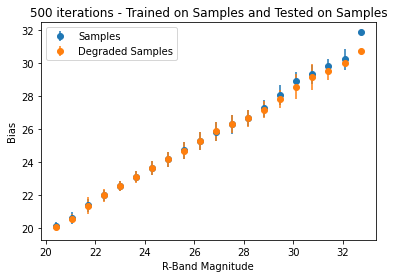

In [127]:
# plot of bias as a function of magnitude 
f = plt.figure(11)
X_s = data[:, 2].reshape(n,1)
centers_s,means_s,stds_s = GPz.bin(X_s[testing,:], X_s[testing,:] - mu_samples, 20)
centers_ds,means_ds,stds_ds = GPz.bin(X_s[testing,:], X_s[testing,:] - mu_degraded_samples, 20)
plt.errorbar(centers_s,means_s,stds_s,fmt='o', label= 'Samples')
plt.errorbar(centers_ds,means_ds,stds_ds,fmt='o', label= 'Degraded Samples')
plt.legend()
plt.xlabel('R-Band Magnitude')
plt.ylabel('Bias')
plt.title('500 iterations - Trained on Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_11.pdf", dpi=300, bbox_inches = "tight")

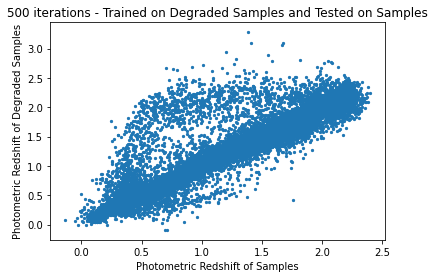

In [128]:
f = plt.figure(12)
plt.scatter(mu_samples, mu_degraded_samples, s=5)
plt.xlabel('Photometric Redshift of Samples')
plt.ylabel('Photometric Redshift of Degraded Samples')
plt.title('500 iterations - Trained on Degraded Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_12.pdf", dpi=300, bbox_inches = "tight")

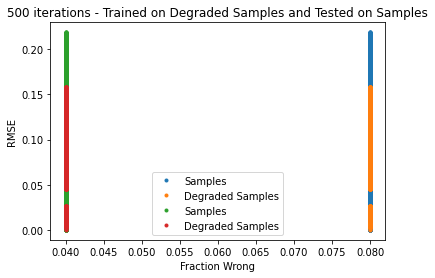

In [129]:
import numpy as np

badness = 5 
x_1 = 0.02*badness
x_2 = 0.01*badness
frac_wrong_1 = np.tile(x_1, 60000)
frac_wrong_2 = np.tile(x_2, 60000)

f = plt.figure(13)
plt.plot(frac_wrong_1, rmse_samples,'.', label="Samples")
plt.plot(frac_wrong_1, rmse_degraded_samples,'.', label="Degraded Samples")
plt.plot(frac_wrong_2, rmse_samples,'.', label="Samples")
plt.plot(frac_wrong_2, rmse_degraded_samples,'.', label="Degraded Samples")
plt.legend()
plt.xlabel('Fraction Wrong')
plt.ylabel('RMSE')
plt.title('500 iterations - Trained on Degraded Samples and Tested on Samples')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=5/badness_5_photoz_13_rmse_vs_frac_wrong.pdf", dpi=300, bbox_inches = "tight")

In [130]:
# save output as a comma seperated values (mean,sigma,model_variance,noise_variance)
savetxt(method+'_'+str(m)+'_'+csl_method+'.csv', array([mu_samples,sigma_samples,modelV_samples,noiseV_samples])[:,:,0].T, delimiter=',')

savetxt(method+'_'+str(m)+'_'+csl_method+'.csv', array([mu_degraded_samples,sigma_degraded_samples,modelV_degraded_samples,noiseV_degraded_samples])[:,:,0].T, delimiter=',')

In [52]:
# CDETOOLS METRICS CODE

!pip install cde-diagnostics
!pip install cdetools
!pip install corner
!pip install FlexCode
!pip install pzflow
!pip install sklearn
!pip install xgboost==0.90


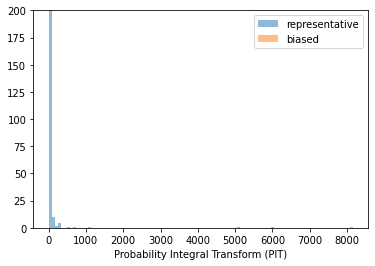

In [135]:
from cdetools import cde_loss, cdf_coverage, hpd_coverage
from scipy.stats import norm
import numpy as np

n_galaxies = 100000   # from the size of samples
n_grid = 200
z_max = 2
z_min = 0

y_grid = np.arange(z_min, z_max, 0.01)
y_grid_bias = np.arange(z_min, z_max, 0.01)

#Creating a Normal Distribution
def normal_dist(y_grid , mu_samples , sigma_samples):
    prob_density = (np.pi*sigma_samples) * np.exp(-0.5*((y_grid-mu_samples)/sigma_samples)**2)
    return prob_density

cde_test = normal_dist(y_grid,mu_samples,sigma_samples)

cde_test_bias = normal_dist(y_grid_bias, mu_degraded_samples, sigma_degraded_samples)


pit_values = cdf_coverage.cdf_coverage(cde_test, y_grid, Y_samples[testing])
pit_values_bias = cdf_coverage.cdf_coverage(cde_test_bias, y_grid_bias, Y_samples[testing])

plt.hist(pit_values, alpha=0.5, bins=100, label='representative')
plt.hist(pit_values_bias, alpha=0.5, bins=100, label='biased')
plt.ylim(0, 200)
plt.legend()
plt.xlabel('Probability Integral Transform (PIT)')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=2/badness_2.2_cde_PIT.pdf", dpi=300, bbox_inches = "tight")


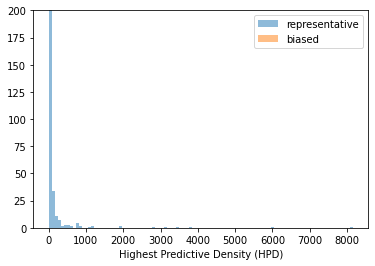

In [136]:
hpd_cov = hpd_coverage.hpd_coverage(cde_test, y_grid, Y_samples[testing])
hpd_cov_bias = hpd_coverage.hpd_coverage(cde_test_bias, y_grid_bias, Y_samples[testing])

plt.hist(hpd_cov, alpha=0.5, bins=100, label='representative')
plt.hist(hpd_cov_bias, alpha=0.5, bins=100, label='biased')
plt.ylim(0,200)
plt.legend()
plt.xlabel('Highest Predictive Density (HPD)')
pb.savefig("/content/drive/MyDrive/Coding/Results/degradation + photoz + cde_metrics plots/Badness=2/badness_2_cde_HPD.pdf", dpi=300, bbox_inches = "tight")

In [137]:
print(cde_loss.cde_loss(cde_test, y_grid, Y_samples[testing]))
print(cde_loss.cde_loss(cde_test_bias, y_grid_bias, Y_samples[testing]))

(2074.5059408437646, 968.810726727334)
(0.03937943082650432, 0.011070167083948033)
